### Initialise

In [284]:
## Import necessary packages
import time;
import numpy as np; 
import matplotlib.pyplot as plt; 
import pandas as pd; 
from sklearn.preprocessing import MinMaxScaler; 
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

In [285]:
# Basic Initialisations
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


### Preprocess Data

In [286]:
data = pd.read_csv('data/clean_data.csv'); 
print(data.columns, "\n\n" ,data.shape); 
data.head()

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
       'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
       'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Substrate concentration(S:g/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)', 'pH(pH:pH)',
       'Temperature(T:K)', 'PAA flow(Fpaa:PAA flow (L/h))',
       'Oil flow(Foil:L/hr)', 'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Ammonia shots(NH3_shots:kgs)',
       '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)'],
      dtype='object') 

 (113935, 19)


,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Substrate concentration(S:g/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),pH(pH:pH),Temperature(T:K),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Ammonia shots(NH3_shots:kgs),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)
0,0.2,30.0,8.0,0.0000,30.118,9.8335,0.0001,0.0,0.6,0.95749,1.017800e-25,58479.0,6.4472,298.22,5.0,22.0,0.480510,0.0,0.0
1,0.4,30.0,8.0,0.0000,51.221,18.1550,0.0001,0.0,0.6,1.00460,1.000000e-03,58487.0,6.4932,298.17,5.0,22.0,0.058147,0.0,0.0
2,0.6,30.0,8.0,0.0000,54.302,9.5982,0.0001,0.0,0.6,1.04980,9.993400e-04,58495.0,6.5425,298.14,5.0,22.0,-0.041505,0.0,0.0
3,0.8,30.0,8.0,0.0000,37.816,4.3395,0.0001,0.0,0.6,1.09420,9.987400e-04,58499.0,6.5753,298.11,5.0,22.0,-0.056737,0.0,0.0
4,1.0,30.0,8.0,0.5181,18.908,1.1045,0.0001,0.0,0.6,1.13700,9.982100e-04,58501.0,6.5825,298.09,5.0,22.0,-0.049975,0.0,0.0


In [287]:
# Scaling from 0-1
scaler = MinMaxScaler(); 

d_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns); 
d_scaled = d_scaled.astype('float32') # Convert to float32 from 64 to increase speed
# d_scaled = d_scaled[:10000]
d_scaled.head()

,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Substrate concentration(S:g/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),pH(pH:pH),Temperature(T:K),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Ammonia shots(NH3_shots:kgs),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)
0,0.000000,0.181818,0.040541,0.000000,0.133858,0.006556,0.0,0.0,0.0,0.008306,1.791808e-27,0.049276,0.767126,0.258427,0.333333,0.0,0.215230,0.0,0.0
1,0.000690,0.181818,0.040541,0.000000,0.227649,0.012103,0.0,0.0,0.0,0.008715,2.763729e-05,0.049480,0.800686,0.249064,0.333333,0.0,0.162455,0.0,0.0
2,0.001380,0.181818,0.040541,0.000000,0.241342,0.006399,0.0,0.0,0.0,0.009107,2.761905e-05,0.049685,0.836653,0.243446,0.333333,0.0,0.150004,0.0,0.0
3,0.002070,0.181818,0.040541,0.000000,0.168071,0.002893,0.0,0.0,0.0,0.009492,2.760247e-05,0.049787,0.860582,0.237828,0.333333,0.0,0.148100,0.0,0.0
4,0.002761,0.181818,0.040541,0.039866,0.084036,0.000736,0.0,0.0,0.0,0.009864,2.758782e-05,0.049838,0.865835,0.234082,0.333333,0.0,0.148945,0.0,0.0


In [288]:
# Split into x and y
x_keys = [
    "Time (h)", "Aeration rate(Fg:L/h)", "Sugar feed rate(Fs:L/h)","Acid flow rate(Fa:L/h)",
    "Base flow rate(Fb:L/h)","Heating/cooling water flow rate(Fc:L/h)","Heating water flow rate(Fh:L/h)",
    "Water for injection/dilution(Fw:L/h)","Substrate concentration(S:g/L)","PAA flow(Fpaa:PAA flow (L/h))",
    "Oil flow(Foil:L/hr)", "Oxygen Uptake Rate(OUR:(g min^{-1}))", "Ammonia shots(NH3_shots:kgs)",
    # Converted variables
    "0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)",
    "Air head pressure(pressure:bar)", "Temperature(T:K)", "pH(pH:pH)", "Vessel Volume(V:L)"
]
x = d_scaled[x_keys]
print(len(x_keys)," keys in ", len(x.columns), "cols")
x.head()

18  keys in  18 cols


,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Substrate concentration(S:g/L),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Ammonia shots(NH3_shots:kgs),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),Air head pressure(pressure:bar),Temperature(T:K),pH(pH:pH),Vessel Volume(V:L)
0,0.000000,0.181818,0.040541,0.000000,0.133858,0.006556,0.0,0.0,0.008306,0.333333,0.0,0.215230,0.0,0.0,0.0,0.258427,0.767126,0.049276
1,0.000690,0.181818,0.040541,0.000000,0.227649,0.012103,0.0,0.0,0.008715,0.333333,0.0,0.162455,0.0,0.0,0.0,0.249064,0.800686,0.049480
2,0.001380,0.181818,0.040541,0.000000,0.241342,0.006399,0.0,0.0,0.009107,0.333333,0.0,0.150004,0.0,0.0,0.0,0.243446,0.836653,0.049685
3,0.002070,0.181818,0.040541,0.000000,0.168071,0.002893,0.0,0.0,0.009492,0.333333,0.0,0.148100,0.0,0.0,0.0,0.237828,0.860582,0.049787
4,0.002761,0.181818,0.040541,0.039866,0.084036,0.000736,0.0,0.0,0.009864,0.333333,0.0,0.148945,0.0,0.0,0.0,0.234082,0.865835,0.049838


In [289]:
y_keys = list(set(d_scaled.columns) - set(x_keys))
y = d_scaled[y_keys]
print(len(y_keys)," keys in ", len(y.columns), "cols")
y.head()

1  keys in  1 cols


,Penicillin concentration(P:g/L)
0,1.791808e-27
1,2.763729e-05
2,2.761905e-05
3,2.760247e-05
4,2.758782e-05


In [290]:
rand = round(time.time() * 1000) % 100; 
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=rand)

print ("x_train: ", x_train.shape)
print ("x_test: ", x_test.shape)

print ("y_train: ", y_train.shape)
print ("y_test: ", y_test.shape)

x_train:  (102541, 18)
x_test:  (11394, 18)
y_train:  (102541, 1)
y_test:  (11394, 1)


In [291]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.x.shape[0]
       
    def __getitem__(self, index):
        return self.x[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 32

# Instantiate training and test data
train_data = Data(x_train.to_numpy(), y_train.to_numpy())
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(x_test.to_numpy(), y_test.to_numpy())
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [292]:
# Just checking if it worked
for batch, (x, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([32, 18])
y shape: torch.Size([32, 1])


In [293]:
input_dim = len(x_keys)
hidden_dim = 950
output_dim = len(y_keys)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.layer_2(x)

        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=18, out_features=950, bias=True)
  (layer_2): Linear(in_features=950, out_features=1, bias=True)
)


In [294]:
learning_rate = 0.00001
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

Training Complete


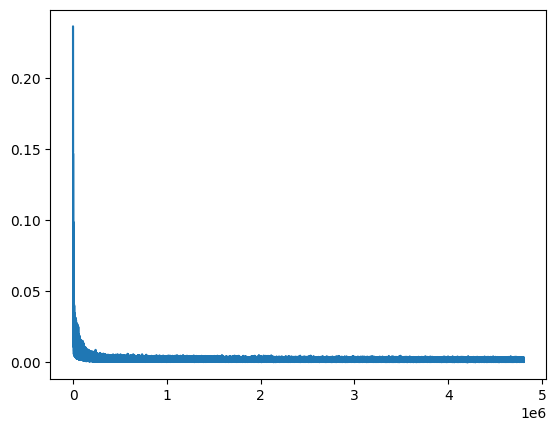

In [295]:
num_epochs = 1500
loss_values = []


for epoch in range(num_epochs):
    for x, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(x)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        # scheduler.step()

# plt.plot(loss_values[500:])
plt.plot(loss_values)
print("Training Complete")

In [296]:
total = 0.0
correct = 0.0
y_pred = []

def isClose(base, known, tol):
    return np.abs((base - known) / base) <= tol

with torch.no_grad():
    for x, y in test_dataloader:
        outputs = model(x)
        np.append(y_pred, outputs)
        np.append(y_test, y)
        # y_pred.append(predicted)
        # y_test.append(y)
        total += y.size(0)
        correct += np.sum(isClose(outputs.numpy(), y.numpy(), tol=0.1))

print(f'Accuracy out of {total} test instances: {(100 * correct) / total}%')

Accuracy out of 11394.0 test instances: 64.21800947867298%
